In [1]:
import numpy as np
import torch
import math
from sklearn import datasets
import matplotlib.pyplot as plt

In [2]:
# Default constants
DNN_HIDDEN_UNITS_DEFAULT = '20'
LEARNING_RATE_DEFAULT = 0.01
MAX_EPOCHS_DEFAULT = 1500
EVAL_FREQ_DEFAULT = 10

In [3]:
def kaiming(m, h):
    return np.random.randn(m, h) * math.sqrt(2. / m)


def normal(loc, scale, in_features, out_features):
    return np.random.normal(loc=loc, scale=scale, size=(in_features, out_features))


class Linear(object):
    def __init__(self, in_features, out_features):
        self.batch_size = None
        self.input = None
        self.output = None
        self.params = dict()
        self.in_features = in_features
        self.out_features = out_features
        self.params['weight'] = normal(0.0, 0.001, in_features, out_features)
        # self.params['weight'] = kaiming(in_features, out_features)
        self.params['bias'] = 0
        self.dw = None
        self.db = None

    def forward(self, x):
        self.input = x
        # print("linear forward", x.shape, self.params['weight'].shape)
        self.output = np.matmul(x, self.params['weight']) + self.params['bias']
        # print("linear forward output size: ", self.output.shape)
        return self.output

    def backward(self, dout):
        # print(dout)
        self.batch_size = dout.shape[0]
        self.dw = np.mean(np.matmul(self.input.transpose(0, 2, 1), dout), axis=0)  # δw = δg * x
        self.db = np.mean(dout, axis=0)
        grad = np.matmul(dout, self.params['weight'].T)
        return grad

    def update(self):
        # print("update dw", self.dw)
        # print("update db", self.db)
        self.params['weight'] = self.params['weight'] - self.dw * LEARNING_RATE_DEFAULT
        self.params['bias'] = self.params['bias'] - self.db * LEARNING_RATE_DEFAULT
        return


class ReLU(object):
    def __init__(self):
        self.out = None

    def forward(self, x):
        self.out = np.where(x > 0, x, 0)
        # print("relu forward output size: ", out.shape)
        return self.out

    def backward(self, dout):
        dout_t = torch.tensor(dout)
        out_t = torch.tensor(self.out)

        idx = torch.where(out_t > 0)
        jd = torch.zeros_like(out_t)
        jd[idx] = 1
        j = torch.diag_embed(jd).squeeze()

        assert dout_t.size(-1) == j.size(-2)
        dx_t = torch.matmul(dout_t, j)
        dx = dx_t.numpy()
        return dx

    def update(self):
        return


class SoftMax(object):
    def __init__(self):
        self.output = None

    def forward(self, x):
        x_max = np.max(x, -1)[:, np.newaxis]
        x = x - x_max
        exp = np.exp(x)
        exp_sum = np.sum(np.exp(x), -1)[:, np.newaxis]
        return exp / exp_sum

    def backward(self, dout):
        return dout

    def update(self):
        return


class CrossEntropy(object):
    def __init__(self):
        self.output = None

    def forward(self, x, y):
        out = -np.sum(y * np.log(x), -1)
        self.output = out
        # print("CE", out.shape)
        return x, out

    def backward(self, x, y):
        batch_size = x.shape[0]
        dx = (x - y)
        return dx

    def update(self):
        return

In [4]:
class MLP(object):

    def __init__(self, n_inputs, n_hidden, n_classes):
        self.layers = []
        for index in range(len(n_hidden)):
            if index == 0:
                self.layers.append(Linear(n_inputs, int(n_hidden[index])))
                self.layers.append(ReLU())
            if index == len(n_hidden)-1:
                self.layers.append(Linear(int(n_hidden[index]), n_classes))
            else:
                self.layers.append(Linear(int(n_hidden[index]), int(n_hidden[index+1])))
                self.layers.append(ReLU())
        self.layers.append(SoftMax())

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        out = x
        return out

    def backward(self, dout):
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
            layer.update()
        return

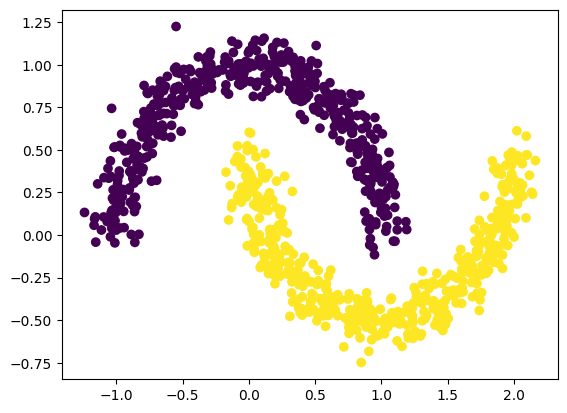

In [5]:
x, y = datasets.make_moons(n_samples=1000, noise=0.08, shuffle=True, random_state=1)
x_input = np.expand_dims(x, axis=1)
y_onehot = np.eye(2)[y]
y_onehot = np.expand_dims(y_onehot, axis=1)

x_input_train = x_input[:800,:,:]
y_onehot_train = y_onehot[:800,:]
x_input_test = x_input[800:,:,:]
y_onehot_test = y_onehot[800:,:]

plt.scatter(x[:,0], x[:,1], c=y)

In [6]:
epoch_set = []
loss_set = []
acc_set = []
acc_train = 0.
acc_test = 0.
acc_test_set = []
loss_test_set = []

In [7]:
def accuracy(predictions, targets, isTest):
    total = predictions.shape[0]
    predictions = np.where(predictions > 0.5, 1, 0)
    acc_cnt = np.sum(predictions * targets)
    return acc_cnt / total

In [8]:
def train(optim, model, epoch):
    
    print("start training MLP...")
    
    if optim == 'BGD':
        for turn in range(epoch):
            pre = model.forward(x_input_train)
            _, loss = CrossEntropy().forward(pre, y_onehot_train)
            loss_avg = np.mean(loss, axis=0)[0]
            acc_train = accuracy(pre, y_onehot_train, isTest=False)
            dout = CrossEntropy().backward(pre, y_onehot_train)
            model.backward(dout)
            if turn > 0 and turn % EVAL_FREQ_DEFAULT == 0:
                pre_test = model.forward(x_input_test)
                acc_test = accuracy(pre_test, y_onehot_test, isTest=False)
                
                epoch_set.append(turn)
                loss_set.append(loss_avg)
                acc_set.append(acc_train)
                acc_test_set.append(acc_test)
                print("The ", turn, " BGD training turn, loss is: ", loss_avg, "accuracy is: ", acc_train)
                print("train accuracy: ", acc_set[-1], "test accuracy: ", acc_test)
    if optim == 'SGD':
        for turn in range(epoch):
            
            for _ in range(4):
                idxs = np.random.randint(0, x_input_train.shape[0] , size=128)
                tmp_X = x_input_train.take(idxs,axis=0)
                tmp_Y = y_onehot_train.take(idxs,axis=0)
            
                pre = model.forward(tmp_X)
                _, loss = CrossEntropy().forward(pre, tmp_Y)
                
                loss_avg = np.mean(loss, axis=0)[0]
                acc_train = accuracy(pre, tmp_Y, isTest=False)
            
            
                dout = CrossEntropy().backward(pre, tmp_Y)
                model.backward(dout)
            
            if turn % EVAL_FREQ_DEFAULT == 0:
                
                idxs = np.random.randint(0, x_input_test.shape[0] , size=128)
                tmp_X_test = x_input_test.take(idxs,axis=0)
                tmp_Y_test = y_onehot_test.take(idxs,axis=0)
                
                pre_test = model.forward(tmp_X_test)
                
                _, loss_test = CrossEntropy().forward(pre_test, tmp_Y_test)
                
                acc_test = accuracy(pre_test, tmp_Y_test, isTest=True)
                loss_test_avg = np.mean(loss_test, axis=0)[0]
                
                epoch_set.append(turn)
                loss_set.append(loss_avg)
                loss_test_set.append(loss_test_avg)
                acc_set.append(acc_train)
                acc_test_set.append(acc_test)
                print("The ", turn, " SGD training turn, loss is: ", loss_avg, "accuracy is: ", acc_train)
                print("train accuracy: ", acc_set[-1], "test accuracy: ", acc_test)
                
    return model

In [9]:
hidden_array = DNN_HIDDEN_UNITS_DEFAULT.split(",")
model = MLP(2, hidden_array, 2)

model = train(optim='SGD', model=model, epoch=1500)

start training MLP...
The  0  SGD training turn, loss is:  0.6931410080183705 accuracy is:  0.515625
train accuracy:  0.515625 test accuracy:  0.4453125
The  10  SGD training turn, loss is:  0.6932076676199068 accuracy is:  0.3828125
train accuracy:  0.3828125 test accuracy:  0.578125
The  20  SGD training turn, loss is:  0.6935610921585562 accuracy is:  0.4375
train accuracy:  0.4375 test accuracy:  0.5078125
The  30  SGD training turn, loss is:  0.6934943010263024 accuracy is:  0.4375
train accuracy:  0.4375 test accuracy:  0.5
The  40  SGD training turn, loss is:  0.6936601145096819 accuracy is:  0.453125
train accuracy:  0.453125 test accuracy:  0.5078125
The  50  SGD training turn, loss is:  0.6930866087465133 accuracy is:  0.515625
train accuracy:  0.515625 test accuracy:  0.53125
The  60  SGD training turn, loss is:  0.6930478513195264 accuracy is:  0.53125
train accuracy:  0.53125 test accuracy:  0.5390625
The  70  SGD training turn, loss is:  0.6931791514166278 accuracy is:  0

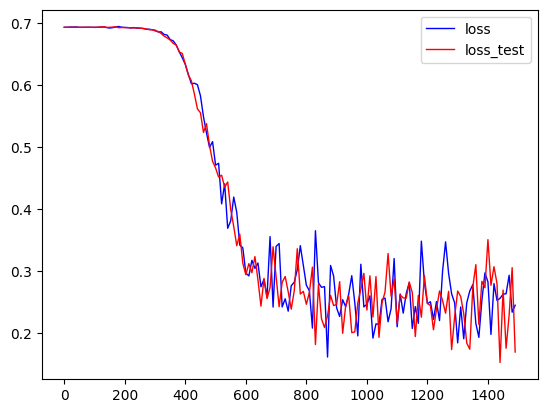

In [10]:
plt.plot(epoch_set, loss_set, linewidth=1, color="blue",label="loss")
plt.plot(epoch_set, loss_test_set, linewidth=1, color="red",label="loss_test")
plt.legend()

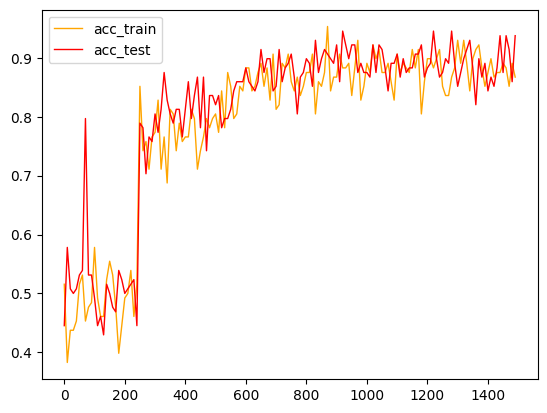

In [11]:
plt.plot(epoch_set, acc_set, linewidth=1, color="orange",label="acc_train")
plt.plot(epoch_set, acc_test_set, linewidth=1, color="red",label="acc_test")
plt.legend()

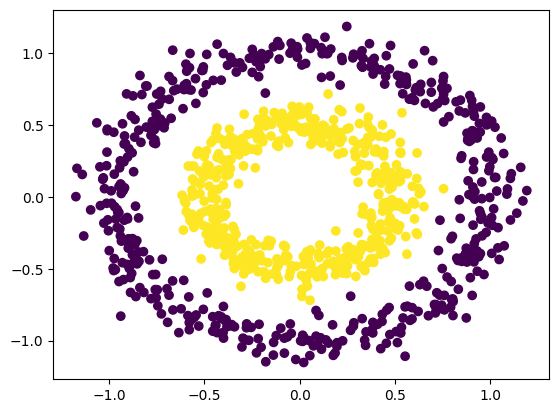

In [12]:
x, y = datasets.make_circles(n_samples=1000, noise=0.08, factor=0.5, shuffle=True, random_state=1)
x_input = np.expand_dims(x, axis=1)
y_onehot = np.eye(2)[y]
y_onehot = np.expand_dims(y_onehot, axis=1)

x_input_train = x_input[:800,:,:]
y_onehot_train = y_onehot[:800,:]
x_input_test = x_input[800:,:,:]
y_onehot_test = y_onehot[800:,:]

plt.scatter(x[:,0], x[:,1], c=y)

In [13]:
epoch_set = []
loss_set = []
acc_set = []
acc_train = 0.
acc_test = 0.
acc_test_set = []
loss_test_set = []

In [14]:
dnn_hidden_units = '20'

hidden_array = dnn_hidden_units.split(",")
model = MLP(2, hidden_array, 2)

model = train(optim='SGD', model=model, epoch=5000)

start training MLP...
The  0  SGD training turn, loss is:  0.693147126230016 accuracy is:  0.59375
train accuracy:  0.59375 test accuracy:  0.5390625
The  10  SGD training turn, loss is:  0.6931488377827641 accuracy is:  0.5
train accuracy:  0.5 test accuracy:  0.484375
The  20  SGD training turn, loss is:  0.6931736293082575 accuracy is:  0.4921875
train accuracy:  0.4921875 test accuracy:  0.53125
The  30  SGD training turn, loss is:  0.6940460991620677 accuracy is:  0.390625
train accuracy:  0.390625 test accuracy:  0.5078125
The  40  SGD training turn, loss is:  0.6930925478546919 accuracy is:  0.609375
train accuracy:  0.609375 test accuracy:  0.4765625
The  50  SGD training turn, loss is:  0.6931288742360666 accuracy is:  0.546875
train accuracy:  0.546875 test accuracy:  0.4296875
The  60  SGD training turn, loss is:  0.6932119050390386 accuracy is:  0.484375
train accuracy:  0.484375 test accuracy:  0.5
The  70  SGD training turn, loss is:  0.6925464001851905 accuracy is:  0.57

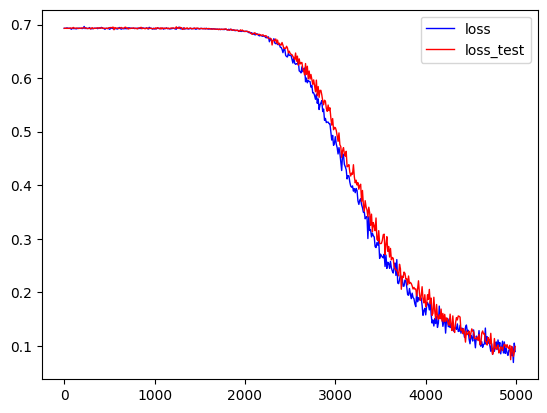

In [15]:
plt.plot(epoch_set, loss_set, linewidth=1, color="blue",label="loss")
plt.plot(epoch_set, loss_test_set, linewidth=1, color="red",label="loss_test")
plt.legend()

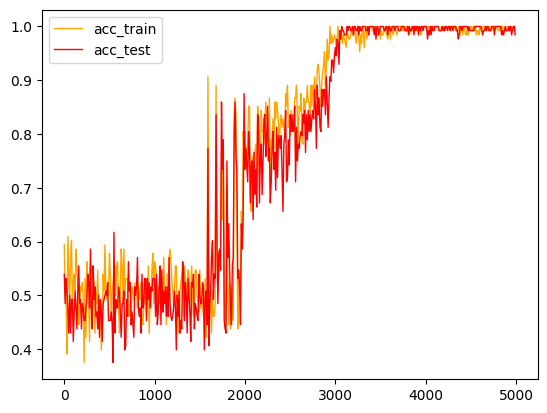

In [16]:
plt.plot(epoch_set, acc_set, linewidth=1, color="orange",label="acc_train")
plt.plot(epoch_set, acc_test_set, linewidth=1, color="red",label="acc_test")
plt.legend()

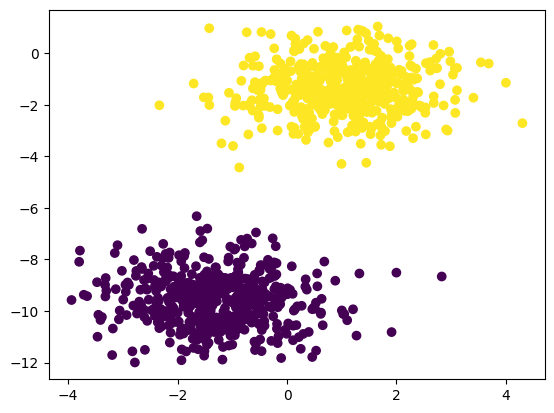

In [17]:
x, y = datasets.make_blobs(n_samples=1000, n_features=2, centers=2, random_state=2)
x_input = np.expand_dims(x, axis=1)
y_onehot = np.eye(2)[y]
y_onehot = np.expand_dims(y_onehot, axis=1)

x_input_train = x_input[:800,:,:]
y_onehot_train = y_onehot[:800,:]
x_input_test = x_input[800:,:,:]
y_onehot_test = y_onehot[800:,:]

plt.scatter(x[:,0], x[:,1], c=y)

In [18]:
epoch_set = []
loss_set = []
acc_set = []
acc_train = 0.
acc_test = 0.
acc_test_set = []
loss_test_set = []

In [19]:
dnn_hidden_units = '20'

hidden_array = dnn_hidden_units.split(",")
model = MLP(2, hidden_array, 2)

model = train(optim='SGD', model=model, epoch=1500)

start training MLP...
The  0  SGD training turn, loss is:  0.6931519971392739 accuracy is:  0.4765625
train accuracy:  0.4765625 test accuracy:  0.5078125
The  10  SGD training turn, loss is:  0.6928919751936025 accuracy is:  0.75
train accuracy:  0.75 test accuracy:  0.4375
The  20  SGD training turn, loss is:  0.6896009533212432 accuracy is:  0.5703125
train accuracy:  0.5703125 test accuracy:  0.46875
The  30  SGD training turn, loss is:  0.6693683745554497 accuracy is:  0.46875
train accuracy:  0.46875 test accuracy:  0.5625
The  40  SGD training turn, loss is:  0.5631372700217399 accuracy is:  0.6015625
train accuracy:  0.6015625 test accuracy:  0.53125
The  50  SGD training turn, loss is:  0.3656975327714145 accuracy is:  0.8125
train accuracy:  0.8125 test accuracy:  0.703125
The  60  SGD training turn, loss is:  0.321167904439047 accuracy is:  0.8359375
train accuracy:  0.8359375 test accuracy:  0.8046875
The  70  SGD training turn, loss is:  0.3640868368904443 accuracy is:  0.

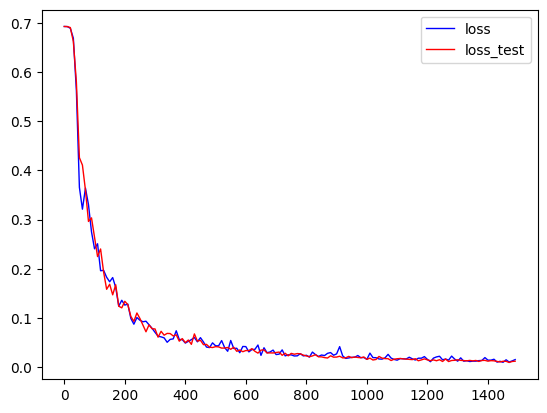

In [20]:
plt.plot(epoch_set, loss_set, linewidth=1, color="blue",label="loss")
plt.plot(epoch_set, loss_test_set, linewidth=1, color="red",label="loss_test")
plt.legend()

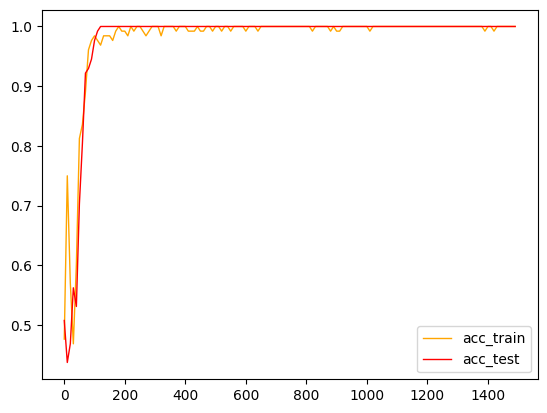

In [21]:
plt.plot(epoch_set, acc_set, linewidth=1, color="orange",label="acc_train")
plt.plot(epoch_set, acc_test_set, linewidth=1, color="red",label="acc_test")
plt.legend()